In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv('/Users/williamyee/Documents/Data Bootcamp/project-5-Air-Quality-Forecast/BE_AQeReporting_2013-2015/BE_5_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv('/Users/williamyee/Documents/Data Bootcamp/project-5-Air-Quality-Forecast/BE_AQeReporting_2013-2015/BE_2013-2015_metadata.csv', sep='\t')

print('aggregated timeseries shape:{}'.format(agg_ts.shape))
print('metadata shape:{}'.format(meta.shape))

aggregated timeseries shape:(65168, 18)
metadata shape:(1289, 26)


In [3]:
pandas_profiling.ProfileReport(agg_ts)

Number of variables,18
Number of observations,65168
Total Missing (%),0.0%
Total size in memory,8.9 MiB
Average record size in memory,144.0 B
Numeric,3
Categorical,6
Boolean,0
Date,2
Text (Unique),0
Rejected,7


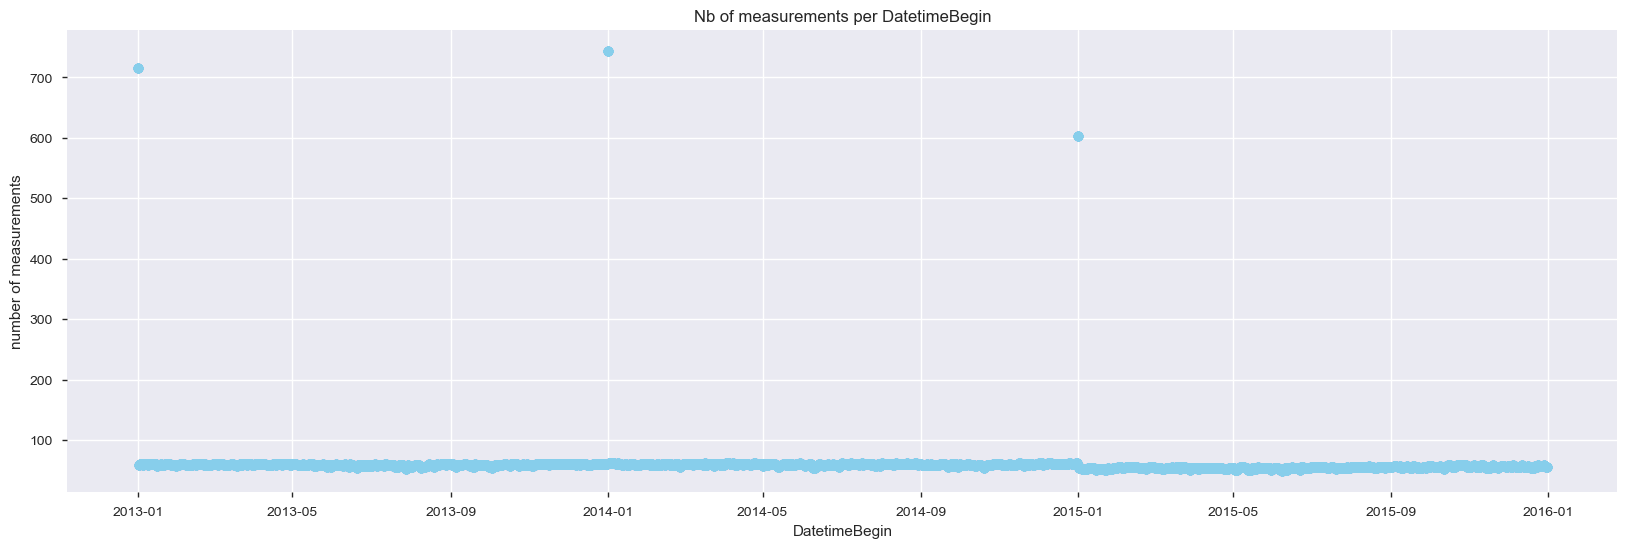

In [4]:
plt.figure(figsize=(20,6))
plt.plot(agg_ts.groupby('DatetimeBegin').count(), 'o', color='skyblue')
plt.title('Nb of measurements per DatetimeBegin')
plt.ylabel('number of measurements')
plt.xlabel('DatetimeBegin')
plt.show()

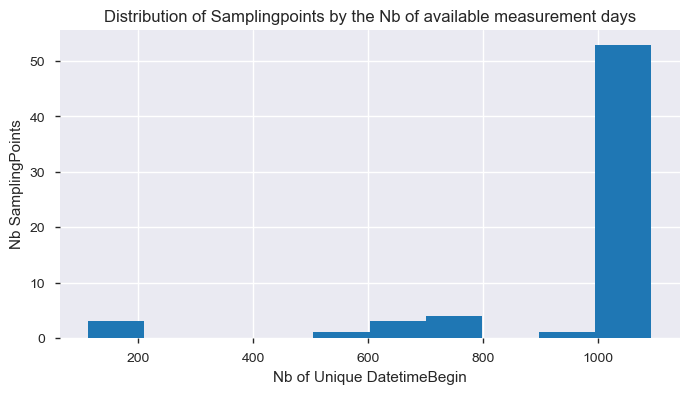

In [5]:
ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
plt.figure(figsize=(8,4))
plt.hist(ser_avail_days.sort_values(ascending=False))
plt.ylabel('Nb SamplingPoints')
plt.xlabel('Nb of Unique DatetimeBegin')
plt.title('Distribution of Samplingpoints by the Nb of available measurement days')
plt.show()

In [6]:
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

In [7]:
df

,SamplingPoint,AirPollutionLevel,DatetimeBegin
0,SPO-BELAB02_00005_100,7.600000,2015-11-22
1,SPO-BELAB02_00005_100,7.666667,2013-01-29
2,SPO-BELAB02_00005_100,8.020833,2014-08-26
3,SPO-BELAB02_00005_100,8.083333,2014-02-08
4,SPO-BELAB02_00005_100,8.125000,2013-11-09
5,SPO-BELAB02_00005_100,8.187500,2013-12-24
6,SPO-BELAB02_00005_100,8.245833,2015-08-17
7,SPO-BELAB02_00005_100,8.354167,2014-01-16
8,SPO-BELAB02_00005_100,8.437500,2013-11-03
9,SPO-BELAB02_00005_100,8.590909,2014-10-07


In [8]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))


0 missing values


In [9]:
df = df.loc['SPO-BETR223_00005_100',:]


In [10]:
df

,AirPollutionLevel
DatetimeBegin,
2013-01-01,8.430667
2013-01-02,21.958500
2013-01-03,16.666833
2013-01-04,17.021000
2013-01-05,28.062667
2013-01-06,34.354333
2013-01-07,18.727522
2013-01-08,18.896000
2013-01-09,14.229333


In [11]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

In [ ]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [ ]:

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [ ]:
n_lag = 14

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

In [ ]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_rnn.json", "w") as m:
     m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [ ]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                                                , epochs=100
                                                , validation_data=valid_data_gen
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

In [ ]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train_data_gen
                                                  , epochs=100
                                                  , validation_data=valid_data_gen
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')